In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
# transmon anharmonicity
import qutip as qt
from qutip import *
import scipy.special as sp

In [2]:
def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
def infidelities(duration):
    string = 'qcpi_'+str(duration)+'.npy'
    pulse = np.load(string)
    if duration == 10:
        duration = duration-1
    k_q = -200e-3 * 2*np.pi  
    #transmon truncation level
    N_q = 5
    #duration
    #number of time intervals for AWG
    total_time=duration
    total_time_steps=2*total_time
    #target
    angle= np.pi
    #range of δ you care
    fluc=np.linspace(-10,10,201)*2*np.pi*1e-3
    # Qutip will do interpolation for drive, which distort piece-wise-constant control. 
    # Here I manually do interpolation to make sure piece-wise-constant pulse.
    resolution = 100
    times = np.linspace(0, total_time, total_time_steps*resolution+1)
    times=np.delete(times, [len(times) - 1])
    osc_control=np.array([np.cos(2*np.pi*5*times),np.sin(2*np.pi*5*times)])
    best_controls=np.zeros_like(osc_control)
    for m in range(len(best_controls)):
        for i in range(len(pulse[0])): 
            for j in range(resolution):
                best_controls[m][i*resolution+j]=pulse[m][i]*(1)
                
    
    
    target_states=np.zeros([N_q,N_q],dtype=complex)
    target_states=Rx(target_states,angle)
    a_q = destroy(N_q)
    n_q = a_q.dag() * a_q
    x_q = a_q + a_q.dag()
    cross = 0e-3 * 2*np.pi
    # without -1/2, strange result when change time origin
    H0 =  1/2*k_q * a_q.dag()**2 * a_q**2
    Hcx=a_q+a_q.dag()
    Hcy=-a_q*1j+1j*a_q.dag()
    H0=H0.data.toarray()
    Hcx=Hcx.data.toarray()
    Hcy=Hcy.data.toarray()
    H_controls=[Hcx,Hcy]
    U_ideal=qt.Qobj(target_states)
    #infidelity withought fluctuation
    options = qt.Options(rtol=1e-10, atol=1e-10)
    qt_H0=qt.Qobj(H0)

    qt_Hcx=qt.Qobj(H_controls[0])
    qt_Hcy=qt.Qobj(H_controls[1])
    qt_tlist=times

    fluc_oper=n_q
    infidelities=np.zeros(len(fluc))
    infidelities_robust=np.zeros(len(fluc))
    options = qt.Options(rtol=1e-10, atol=1e-10)
    U_ideal=qt.Qobj(target_states)
    x=np.pi/angle
    for i in range(len(fluc)):
        qt_H0=qt.Qobj(H0+fluc[i]*fluc_oper)
        qt_tlist=times
        qt_cx = best_controls[0]
        qt_cy = best_controls[1]
        qt_H=[qt_H0,[qt_Hcx,qt_cx],[qt_Hcy,qt_cy]]
        output = qt.propagator(qt_H, qt_tlist, options=options)
        infidelities[i]=1-np.abs(np.trace((U_ideal*output[-1].dag())))**2/4
    return np.mean(infidelities)

In [39]:
from joblib import Parallel, delayed
durations = [10, 20, 30, 40, 50, 60, 70, 80]

# Use joblib to parallelize the infidelities function
results = Parallel(n_jobs=-1)(delayed(infidelities)(duration) for duration in durations)


In [40]:
results

[0.0032463102730425856,
 0.0002564991139313211,
 0.0016854158182451184,
 0.007618872033338548,
 0.008062655239110917,
 0.004172288962376962,
 0.021455436625821483,
 0.0037640035435199757]

In [3]:
pulse = np.load('qcpi_20.npy')
k_q = -200e-3 * 2*np.pi  
#transmon truncation level
N_q = 5
#duration
total_time = 20
#number of time intervals for AWG
total_time_steps=2*total_time
#target
angle= np.pi
#range of δ you care
fluc=np.linspace(-20,20,401)*2*np.pi*1e-3
# Qutip will do interpolation for drive, which distort piece-wise-constant control. 
# Here I manually do interpolation to make sure piece-wise-constant pulse.
resolution = 100
times = np.linspace(0, total_time, total_time_steps*resolution+1)
times=np.delete(times, [len(times) - 1])
osc_control=np.array([np.cos(2*np.pi*5*times),np.sin(2*np.pi*5*times)])
best_controls=np.zeros_like(osc_control)
for m in range(len(best_controls)):
    for i in range(len(pulse[0])): 
        for j in range(resolution):
            best_controls[m][i*resolution+j]=pulse[m][i]*(1)

(-0.5, 0.5)

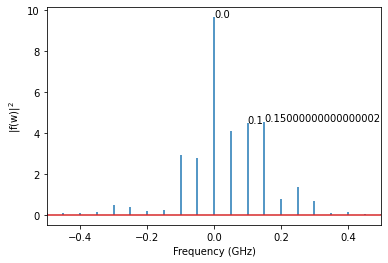

In [9]:
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
from numpy.fft import fft,fftfreq,ifft
fourier = np.abs(fft(pulse[0]-1j*pulse[1]))
freq = fftfreq(len(times), times[1]-times[0])
max_index = np.argpartition(abs(fourier), -3)[-3:]
fig,ax=plt.subplots()
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('|f(w)|$^2$')
ax.stem(freq, fourier, markerfmt=' ', label='')
for index in max_index:
    ax.annotate('{}'.format(freq[index]), xy=(freq[index], fourier[index]))
ax.set_xlim(-0.5,0.5)

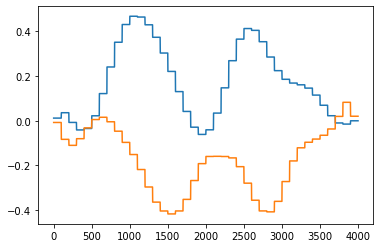

In [6]:
plt.plot(best_controls[0])
plt.plot(best_controls[1])

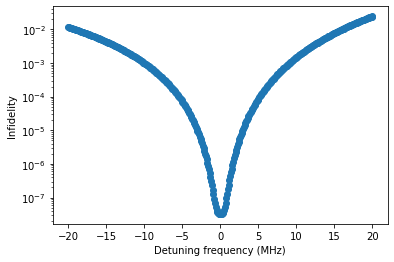

In [67]:
def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
import qutip as qt
from qutip import *
import scipy.special as sp
target_states=np.zeros([N_q,N_q],dtype=complex)
target_states=Rx(target_states,angle)
a_q = destroy(N_q)
n_q = a_q.dag() * a_q
x_q = a_q + a_q.dag()
cross = 0e-3 * 2*np.pi
# without -1/2, strange result when change time origin
H0 =  1/2*k_q * a_q.dag()**2 * a_q**2
Hcx=a_q+a_q.dag()
Hcy=-a_q*1j+1j*a_q.dag()
H0=H0.data.toarray()
Hcx=Hcx.data.toarray()
Hcy=Hcy.data.toarray()
H_controls=[Hcx,Hcy]
U_ideal=qt.Qobj(target_states)
#infidelity withought fluctuation
import qutip as qt
options = qt.Options(rtol=1e-10, atol=1e-10)
qt_H0=qt.Qobj(H0)

qt_Hcx=qt.Qobj(H_controls[0])
qt_Hcy=qt.Qobj(H_controls[1])
qt_tlist=times

fluc_oper=n_q
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
options = qt.Options(rtol=1e-10, atol=1e-10)
U_ideal=qt.Qobj(target_states)
x=np.pi/angle
for i in range(len(fluc)):
    qt_H0=qt.Qobj(H0+fluc[i]*fluc_oper)
    qt_tlist=times
    qt_cx = best_controls[0]
    qt_cy = best_controls[1]
    qt_H=[qt_H0,[qt_Hcx,qt_cx],[qt_Hcy,qt_cy]]
    output = qt.propagator(qt_H, qt_tlist, options=options)
    infidelities[i]=1-np.abs(np.trace((U_ideal*output[-1].dag())))**2/4
fig,ax=plt.subplots()
ax.plot(fluc/(2*np.pi)*1e3,infidelities)
ax.set_xlabel('Detuning frequency (MHz)')
ax.set_ylabel('Infidelity')
ax.scatter(fluc/(2*np.pi)*1e3,infidelities)
ax.set_yscale('log')

In [93]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy.special as sp
import scipy
from scipy.interpolate import interp1d

N_q = 5

a_q = destroy(N_q)
n_q = a_q.dag() * a_q
x_q = a_q + a_q.dag()
def func(i):

    cross = fluc[i]
    
    anhar = 200 * 1e-3 * 2*np.pi   # need to modify in python file 

    kerr_q = anhar / 2
    
    k_q = -200e-3 * 2*np.pi  

    H0 = ( cross * n_q 
          + 1/2*k_q * a_q.dag()**2 * a_q**2 
         )

    Hcx=a_q+a_q.dag()
    Hcy=-a_q*1j+1j*a_q.dag()

    target_states=np.zeros((N_q, N_q), dtype=np.complex128)
    target_states[0,1]=1
    target_states[1,0]=1
    target_sup = np.kron(target_states,target_states)
    U_ideal = Qobj(target_states)

    options = qt.Options(rtol=1e-10, atol=1e-10)

    
    # qoc part 
    qt_cx = best_controls[0]
    qt_cy = best_controls[1]
    qt_H=[H0,[Hcx,qt_cx],[Hcy,qt_cy]]
    T_1 = 50000
    T_phi = 50000
    output = qt.propagator(qt_H, times, c_op_list=[np.sqrt(1/T_1)*a_q,2*np.sqrt(1/T_phi)*n_q], args={}, options=options)
    robust = 1-1/4*np.abs(np.trace(np.transpose(output[-1].data.toarray()@target_sup)))
    
    return robust

In [88]:
func(0)

0.0008069233343729332

In [94]:
RESULT = parallel_map(func, range(len(fluc)), progress_bar=True)

10.2%. Run time: 163.39s. Est. time left: 00:00:23:54
20.2%. Run time: 304.00s. Est. time left: 00:00:20:00
30.2%. Run time: 454.25s. Est. time left: 00:00:17:31
40.1%. Run time: 603.97s. Est. time left: 00:00:15:00
50.1%. Run time: 746.40s. Est. time left: 00:00:12:22
60.1%. Run time: 886.11s. Est. time left: 00:00:09:48
70.1%. Run time: 1022.87s. Est. time left: 00:00:07:16
80.0%. Run time: 1158.21s. Est. time left: 00:00:04:48
90.0%. Run time: 1294.97s. Est. time left: 00:00:02:23
100.0%. Run time: 1421.85s. Est. time left: 00:00:00:00
Total run time: 1421.92s


In [95]:
from qutip import qsave

In [96]:
rrr = [results,infidelities,RESULT]

In [97]:
qsave(rrr,'qctrl_result')

In [1]:
np.mean(infidelities)

NameError: name 'np' is not defined

In [ ]:
plt.plot(RESULT)